## Twitter US Airline Sentiment Analysis
In this project, I perform sentiment analysis on travellers' expressing their feelings on Airlines on Twitter. I first try to categorize the sentiment using VADER bag-of-words approach. Next, I connect to the OpenAI API to get ChatGPT to respond with the sentiment category for each tweet.

In [293]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [294]:
#Reading CSV data
df = pd.read_csv('Tweets.csv')

### Exploring the data

In [295]:
df.shape

(14640, 15)

In [296]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [297]:
df['text'].values[35]

'Nice RT @VirginAmerica: Vibe with the moodlight from takeoff to touchdown. #MoodlitMonday #ScienceBehindTheExperience http://t.co/Y7O0uNxTQP'

#### The 'text' field has the tweet, the 'airline_sentiment' field has the human labelled sentiment - neutral, positive or negative.

### Plotting distributin of airline_sentiment

[Text(0, 0, '9178'), Text(0, 0, '3099'), Text(0, 0, '2363')]

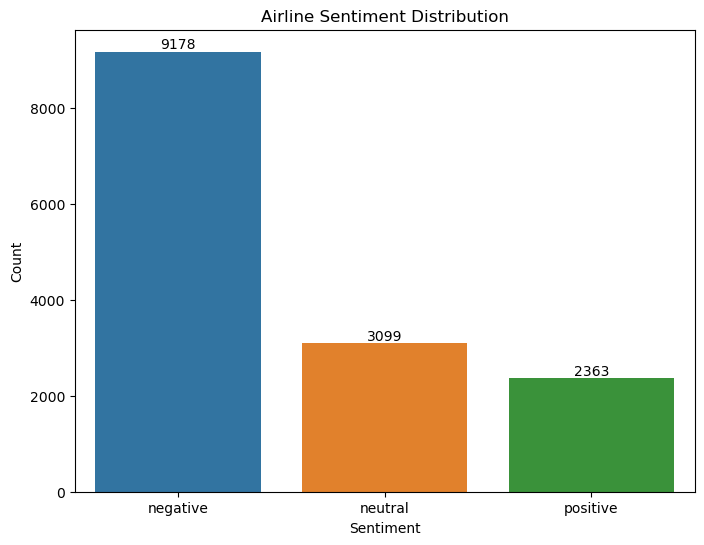

In [298]:
plt.figure(figsize = (8,6))
ax = sns.countplot(data = df, x = 'airline_sentiment', order = ['negative', 'neutral', 'positive'])
plt.title('Airline Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
ax.bar_label(ax.containers[0])

#### Majority of tweets are negative!

### Plotting distribution of airline_sentiment across by different airlines

Text(0, 0.5, 'Count')

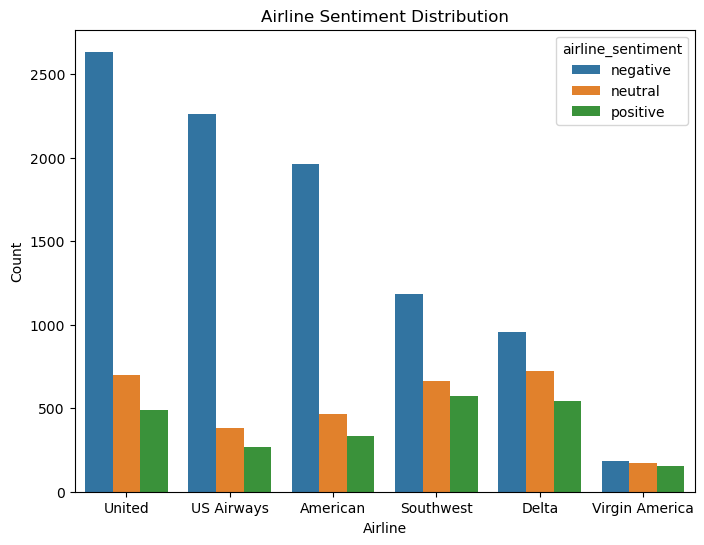

In [299]:
plt.figure(figsize = (8,6))
sns.countplot(data = df, x = 'airline', order = df['airline'].value_counts().index, hue_order = df['airline_sentiment'].value_counts().index, hue = 'airline_sentiment')
plt.title('Airline Sentiment Distribution')
plt.xlabel('Airline')
plt.ylabel('Count')

#### Popular airlines have a higher ratio of negative tweets.

### Plot of negative reason distribution

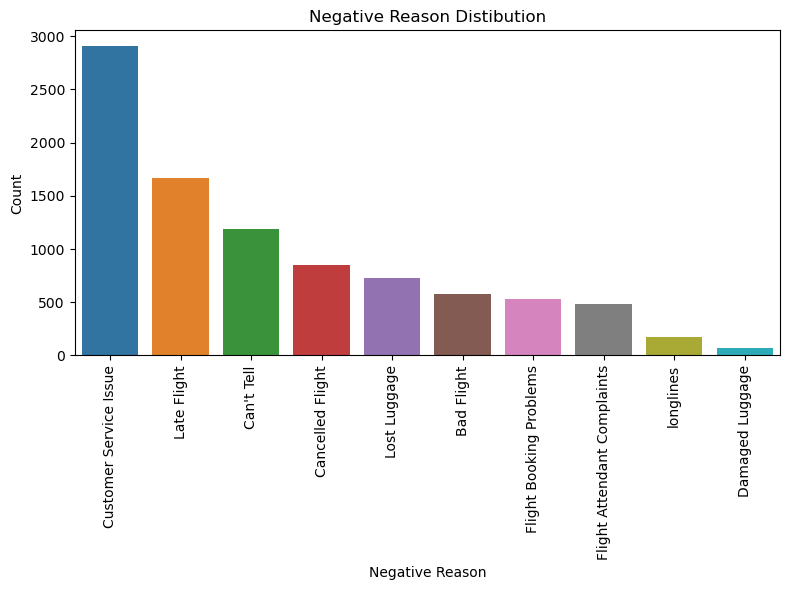

In [300]:
plt.figure(figsize = (8,6))
sns.countplot(data = df, x = 'negativereason', order = df['negativereason'].value_counts().index)
plt.title('Negative Reason Distibution')
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

#### Customer Service Issue tops the list of complaint reasons by travelers.

## Sentiment Analysis

### Using VADER

In [301]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [302]:
sia = SentimentIntensityAnalyzer()

In [303]:
df['VADERScore']=df['text'].apply(sia.polarity_scores)

In [304]:
df['neg'] = [d['neg'] for d in df['VADERScore']]
df['neu'] = [d['neu'] for d in df['VADERScore']]
df['pos'] = [d['pos'] for d in df['VADERScore']]
df['compound'] = [d['compound'] for d in df['VADERScore']]

In [305]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [282]:
def vaderSentiment(str):
    if str == 0:
        return 'neutral'
    if str < 0:
        return 'negative'
    if str > 0:
        return 'positive'

In [308]:
df['VADERsentiment'] = df['compound'].apply(vaderSentiment)

In [314]:
(df['VADERsentiment'] == df['airline_sentiment']).value_counts()

True     8003
False    6637
Name: count, dtype: int64

#### 45% of responses don't match with human labelled sentiment categories.

<Axes: xlabel='airline_sentiment', ylabel='compound'>

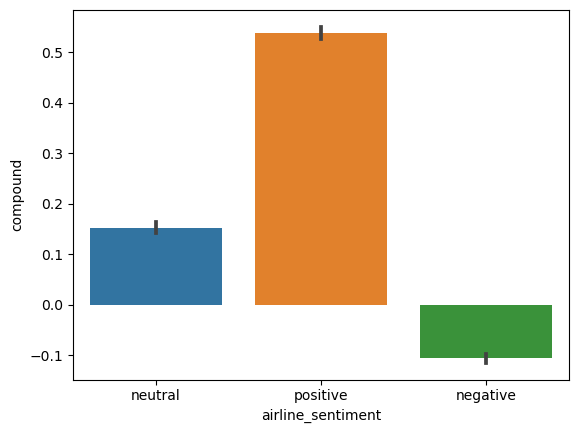

In [312]:
sns.barplot(data = df, x = 'airline_sentiment', y = 'compound')

[Text(0, 0, '1357'), Text(0, 0, '2065'), Text(0, 0, '2797')]

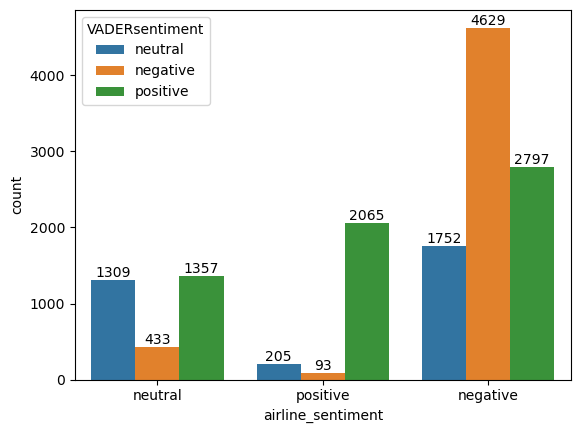

In [313]:
ax = sns.countplot(data = df, x = 'airline_sentiment', hue = 'VADERsentiment')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])

#### This method performs well for positive tweets, but does poorly while categorizing neutral/negative sentiments.

### Using ChatGPT

In [221]:
#Import libraries
import os
import openai
import json
import ast

# Put OpenAI API key in a separate text file in the same directory
with open('gpt_apikey.txt') as api_key:
    openai_key = api_key.readline()
client = openai.OpenAI(api_key = openai_key)

In [222]:
#Function to connect to and get ChatGPT response 
def analyze_sentiment(text):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages =[
          {"role": "system", "content": "You are a sentiment analyser."},
          {"role": "user", "content": f"Please determine the sentiment of the following text: {text} Sentiment (positive, neutral or negative). Response should be one word, in lower case "}
      ]
    )
    sentiment = response.choices[0].message.content
    return sentiment

In [223]:
#Perform analysis on a subset of the data
df1000 = df.head(1000)
df1000['OpenAISentimentAnalysis'] = df1000['text'].apply(analyze_sentiment)

In [252]:
df1000['OpenAISentimentAnalysis'].value_counts()

OpenAISentimentAnalysis
negative    518
positive    351
neutral     131
Name: count, dtype: int64

In [250]:
#Clean ChatGPT response
def cleanAIResponse(str):
    if 'negative' in str:
        return 'negative'
    if str == 'mixed':
        return 'neutral'
    else:
        return str.lower().rstrip()

In [251]:
df1000['OpenAISentimentAnalysis'] = df1000['OpenAISentimentAnalysis'].apply(cleanAIResponse)

/var/folders/vt/n5m4bwz90735jcwwpbgfrz0c0000gn/T/ipykernel_20458/1547765738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1000['OpenAISentimentAnalysis'] = df1000['OpenAISentimentAnalysis'].apply(updateOpenAI)


In [292]:
df1000[df1000['airline_sentiment'] == df1000['OpenAISentimentAnalysis']][['text', 'airline_sentiment', 'OpenAISentimentAnalysis']]

,text,airline_sentiment,OpenAISentimentAnalysis
3,@VirginAmerica it's really aggressive to blast...,negative,negative
4,@VirginAmerica and it's a really big bad thing...,negative,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,positive
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,positive
...,...,...,...
995,@united by the time I finally get to Dallas I ...,negative,negative
996,@united I'm trying to get to my final destinat...,negative,negative
997,@united that guy really has no customer servic...,negative,negative
998,@united he has no priority and Iove it,positive,positive


#### Roughly 75% of responses match between human label and ChatGPT analysis.

### Comparing performance for each sentiment category:

[Text(0, 0, '94'), Text(0, 0, '5'), Text(0, 0, '32')]

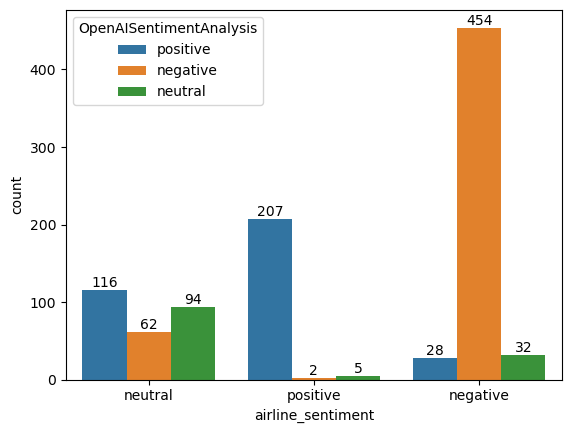

In [261]:
ax = sns.countplot(data = df1000, x = 'airline_sentiment', hue = 'OpenAISentimentAnalysis')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])

#### ChatGPT performs well when the tweet sentiment is clearly positive or negative. On the downside, it tries to forcefit more neutral tweets as either positive or negative.